In [387]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [388]:
input_data = 'data02/data_set04.csv'
trade_history_long = 'data02/trade_history_long.csv'
trade_history_short = 'data02/trade_history_short.csv'

In [389]:
reward_price = 1.25
risk_price = 0.90

In [390]:
def openTradeHistory():
    with open(trade_history_long, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["time", "type", "current", "reward", "risk", "close"])
        file.close()
        
    with open(trade_history_short, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["time", "type", "current", "reward", "risk", "close"])
        file.close()

In [391]:
def createTradeHistoryLong(trade_detail):
    with open(trade_history_long, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(trade_detail)
        file.close()

In [392]:
def createTradeHistoryShort(trade_detail):
    with open(trade_history_short, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(trade_detail)
        file.close()

In [393]:
def closeTrade(current_price, short_price):
    df_l = pd.read_csv(trade_history_long)
    for index_l, row_l in df_l.iterrows():
        if row_l['close'] != 0:
            continue
        if row_l['risk'] >= short_price:
            df_l.loc[index_l, 'close'] = current_price
        if row_l['reward'] <= short_price:
            df_l.loc[index_l, 'risk'] = short_price - (reward_price * 0.50)
            df_l.loc[index_l, 'reward'] = short_price + (reward_price * 0.75)
            
    df_l.to_csv(trade_history_long, index=False)
    
    df_s = pd.read_csv(trade_history_short)
    for index_s, row_s in df_s.iterrows():
        if row_s['close'] != 0:
            continue
        if row_s['risk'] <= short_price:
            df_s.loc[index_s, 'close'] = current_price
        if row_s['reward'] >= short_price:
            df_s.loc[index_s, 'risk'] = short_price + (reward_price * 0.50)
            df_s.loc[index_s, 'reward'] = short_price - (reward_price * 0.75)
            
    df_s.to_csv(trade_history_short, index=False)

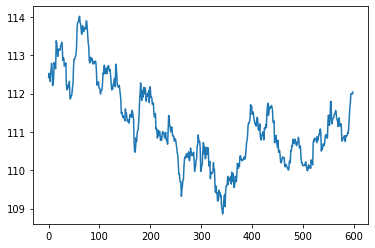

In [394]:
stockData = pd.Series([],dtype='float64') 
original_data = pd.read_csv(input_data)
#original_data = original_data['price']
ticker = original_data.iloc[:, 1]
#ticker = original_data[0:375]

openTradeHistory()
plt.plot(ticker)

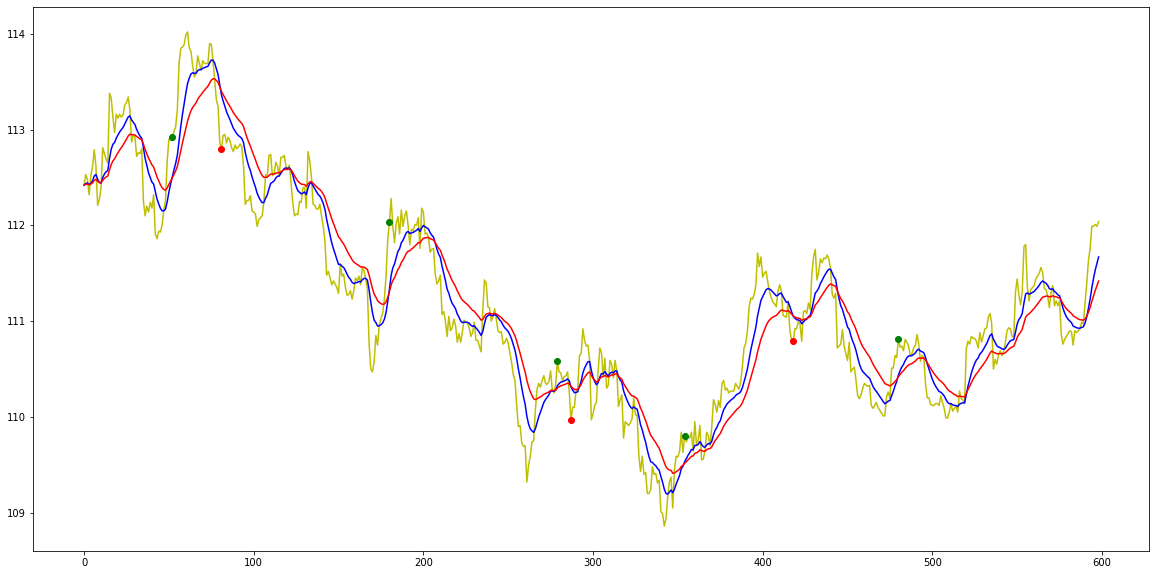

In [395]:
plt.figure(figsize=(20, 10))
plt.plot(ticker, c='y')

for val in ticker:
    stockData[len(stockData)] = val
    
    if len(stockData) > 50:
        nanoWindow = stockData.ewm(span=4, adjust=False).mean()
        shortWindow = stockData.ewm(span=12, adjust=False).mean()
        longWindow = stockData.ewm(span=26, adjust=False).mean()
        closeTrade(val, nanoWindow[len(nanoWindow) - 1])
        idx = len(stockData) - 1
        
        if shortWindow[idx-1] < longWindow[idx-1] and shortWindow[idx] >= longWindow[idx]:
            df_l = pd.read_csv(trade_history_long)
            last_long = df_l.tail(1).close.tolist()
            if len(last_long) != 0 and last_long[0] == 0:
                continue
            plt.plot(idx, val, c='g', marker='o') #Long
            createTradeHistoryLong([idx, "long", val, (val+reward_price), (val-risk_price), 0])
    
        if shortWindow[idx-1] > longWindow[idx-1] and shortWindow[idx] < longWindow[idx]:
            df_s = pd.read_csv(trade_history_short)
            last_short = df_s.tail(1).close.tolist()
            if len(last_short) != 0 and last_short[0] == 0:
                continue
            plt.plot(idx, val, c='r', marker='o') #short
            createTradeHistoryShort([idx, "short", val, (val-reward_price), (val+risk_price), 0])
            
plt.plot(shortWindow, c='b')
plt.plot(longWindow, c='r')

In [396]:
df_l = pd.read_csv(trade_history_long)
last_long = df_l.tail(1).close.tolist()
if len(last_long) != 0 and last_long[0] == 0:
    df_l.loc[len(df_l.index)-1, 'close'] = ticker[len(ticker)-1]
    df_l.to_csv(trade_history_long, index=False)
    
df_s = pd.read_csv(trade_history_short)
last_short = df_s.tail(1).close.tolist()
if len(last_short) != 0 and last_short[0] == 0:
    df_s.loc[len(df_s.index)-1, 'close'] = ticker[len(ticker)-1]
    df_s.to_csv(trade_history_short, index=False)

In [397]:
profit_l = 0.0
df_l = pd.read_csv(trade_history_long)
for index_l, row_l in df_l.iterrows():
    if row_l['close'] == 0:
        continue
    profit_l = profit_l + (row_l['close'] - row_l['current'])

print('profit by long {}',profit_l)

profit_s = 0.0
df_s = pd.read_csv(trade_history_short)
for index_s, row_s in df_s.iterrows():
    if row_s['close'] == 0:
        continue
    profit_s = profit_s + (row_s['current'] - row_s['close'])

print('profit by short {}',profit_s)

print('total profit{}',(profit_l+profit_s))

profit by long {} -1.4599999999999937
profit by short {} 0.10999999999999943
total profit{} -1.3499999999999943
